<a href="https://colab.research.google.com/github/hypnopump/alphafold2/blob/main/notebooks/egnn_esm_end2end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get env ready

In [1]:
!pip install sidechainnet proDy einops
!git clone https://github.com/hypnopump/egnn-pytorch
!git clone https://github.com/hypnopump/geometric-vector-perceptron
!nvidia-smi

     |████████████████████████████████| 46.9MB 68kB/s 
     |████████████████████████████████| 6.3MB 33.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3MB 43.9MB/s 
  Created wheel for proDy: filename=ProDy-2.0-cp37-cp37m-linux_x86_64.whl size=6653605 sha256=b7c4361546ec03f557441e792023229a8b0bda75631b45264b667a2232c2796c
  Stored in directory: /root/.cache/pip/wheels/e2/be/52/a879e8adf713065f8f11e15c56073b311e82ecc85bbeb8b6c4
Successfully built proDy
Cloning into 'egnn-pytorch'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 496 (delta 120), reused 181 (delta 77), pack-reused 251
Receiving objects: 100% (496/496), 1.24 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (251/251), done.
Cloning into 'geometric-vector-perceptron'...
remote: Enumerating object

In [2]:
import torch
torch.__version__

'1.8.1+cu101'

In [3]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 2.6MB 24.7MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.5MB 25.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 1.0MB 6.1MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
     |████████████████████████████████| 389kB 6.3MB/s 
     |████████████████████████████████| 194kB 18.8MB/s 
     |████████████████████████████████| 235kB 42.8MB/s 
     |████████████████████████████████| 2.2MB 54.6MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp37-none-any.whl size=322719 sha256=4b77cd85d541fed1a9ed4bd37d6eba95d943f6cf52d738dd44672fb8d1e3c417
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a3

In [4]:
!pip install alphafold2-pytorch

     |████████████████████████████████| 18.5MB 169kB/s 
     |████████████████████████████████| 6.1MB 23.1MB/s 
     |████████████████████████████████| 839kB 51.6MB/s 
     |████████████████████████████████| 184kB 48.0MB/s 
     |████████████████████████████████| 276kB 55.5MB/s 
     |████████████████████████████████| 112kB 57.4MB/s 
     |████████████████████████████████| 829kB 50.6MB/s 
     |████████████████████████████████| 1.3MB 48.7MB/s 
     |████████████████████████████████| 296kB 59.2MB/s 
     |████████████████████████████████| 143kB 54.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=cf3d7b362af1face2ad3d785e982268a4efbf7fa6d0ed00b7e0d83dc586d64b0
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=931300c9401bbbcf06fe7e4ed766965674de33383cec616ced43f2f4f698cd29
  Stored in directo

In [3]:
# get CASP7 data copied from drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
!mkdir sidechainnet_data
!cp drive/MyDrive/sidechainnet_casp7_30.pkl sidechainnet_data/sidechainnet_casp7_30.pkl

## Start code

### Import and sample data loading

In [4]:
import os
import sys
import time

sys.path.append("geometric-vector-perceptron/geometric_vector_perceptron")
sys.path.append("geometric-vector-perceptron/examples")
sys.path.append("egnn-pytorch/egnn_pytorch")

In [5]:
import torch
import torch_sparse
import numpy as np
from einops import rearrange, repeat
import matplotlib.pyplot as plt
# custom model
from egnn_pytorch import *
from geometric_vector_perceptron import *
# custom utils
from data_handler import *
from data_utils import *
# process and dataset
import gc
import joblib
from tqdm import tqdm
from functools import partial

In [6]:
from alphafold2_pytorch import Alphafold2
import alphafold2_pytorch.constants as constants

import alphafold2_pytorch.utils as af2utils

In [7]:
# data
import sidechainnet
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cpu")

In [9]:
# MIN_LEN = 70
MAX_LEN = 100000
MIN_LEN = 100
MAX_PROTS = 360

In [69]:
# check dataloader works
dataloaders_ = sidechainnet.load(casp_version=7, with_pytorch="dataloaders",  batch_size = 1, dynamic_batching = False)
dataloaders_.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
train_examples_storer = [get_prot(dataloader_=dataloaders_, vocab_=VOCAB,
                                  min_len=MIN_LEN, max_len=MAX_LEN, verbose=0)\
                         for i in tqdm(range(3))]

# dataloaders won't work on my windows (idk why, so load examples from disk and train)
# train_examples_storer = joblib.load("sidechainnet_data/800_under_200.joblib"

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


In [70]:
## AF2 data utils
def cycle(loader, cond = lambda x: True):
    while True:
        for data in loader:
            if not cond(data):
                continue
            yield data

data = dataloaders_

In [71]:
data = iter(data['train'])
data_cond = lambda t: t[1].shape[1] < THRESHOLD_LENGTH
dl = cycle(data, data_cond)

### Params for AF2 and ESM embedding

In [13]:
FEATURES = "fake_esm_embeddings" # "esm" # one of ["esm", "msa", None]
DEVICE = None#  torch.device("cuda" if torch.cuda.is_available() else "cpu") # defaults to cuda if available, else cpu
NUM_BATCHES = int(1e5)
GRADIENT_ACCUMULATE_EVERY = 1 #16
LEARNING_RATE = 3e-4
IGNORE_INDEX = -100
THRESHOLD_LENGTH = 250
TO_PDB = False
SAVE_DIR = ""

In [14]:
constants.DEVICE = device
DEVICE = constants.DEVICE
DISTOGRAM_BUCKETS = constants.DISTOGRAM_BUCKETS

In [15]:
if FEATURES == "esm":
    # from pytorch hub (almost 30gb)
    embedd_model, alphabet = torch.hub.load("facebookresearch/esm", "esm1b_t33_650M_UR50S")
    ##  alternatively do
    # import esm # after installing esm
    # model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
    batch_converter = alphabet.get_batch_converter()

In [72]:
model = Alphafold2(
    dim = 128,
    depth = 1,
    heads = 1, # Maybe set even lower?
    dim_head = 16, # Maybe set even lower?
    predict_coords = False,
    num_backbone_atoms = 4,
).to(DEVICE)

### Custom data loader for egnn

In [17]:
# overwrite GVP function by this one - faster
def encode_whole_protein(seq, true_coords, padding_seq,
                         needed_info = { "cutoffs": [2, 5, 10],
                                          "bond_scales": [0.5, 1, 2]}, free_mem=False):
    """ Encodes a whole protein. In points + vectors. """
    device, precise = true_coords.device, true_coords.type()
    #################
    # encode points #
    #################
    cloud_mask = torch.tensor(scn_cloud_mask(seq[:-padding_seq or None])).bool().to(device)
    flat_mask = rearrange(cloud_mask, 'l c -> (l c)')
    coords_wrap = rearrange(true_coords, '(l c) d -> l c d', c=14)[:-padding_seq or None] 
    # embedd everything

    # position in backbone embedding
    aa_pos = encode_dist( torch.arange(len(seq[:-padding_seq or None]), device=device).float(), scales=needed_info["aa_pos_scales"])
    atom_pos = chain2atoms(aa_pos)[cloud_mask]

    # atom identity embedding
    atom_id_embedds = torch.stack([SUPREME_INFO[k]["atom_id_embedd"] for k in seq[:-padding_seq or None]], 
                                  dim=0)[cloud_mask].to(device)
    # aa embedding
    seq_int = torch.tensor([AAS2NUM[aa] for aa in seq[:-padding_seq or None]], device=device).long()
    aa_id_embedds   = chain2atoms(seq_int, mask=cloud_mask)

    ################
    # encode bonds #
    ################
    bond_info = encode_whole_bonds(x = coords_wrap[cloud_mask],
                                   x_format = "coords",
                                   embedd_info = {},
                                   needed_info = needed_info )
    whole_bond_idxs, whole_bond_enc, bond_embedd_info = bond_info
    #########
    # merge #
    #########

    # concat so that final is [vector_dims, scalar_dims]
    point_n_vectors = 0
    point_n_scalars = 2*len(needed_info["aa_pos_scales"]) + 1 +\
                      2 # the last 2 are to be embedded yet

    whole_point_enc = torch.cat([ atom_pos, # 2n+1
                                  atom_id_embedds.unsqueeze(-1),
                                  aa_id_embedds.unsqueeze(-1) ], dim=-1) # the last 2 are yet to be embedded
    if free_mem:
        del cloud_mask, atom_pos, atom_id_embedds, aa_id_embedds

    # record embedding dimensions
    point_embedd_info = {"point_n_vectors": point_n_vectors,
                         "point_n_scalars": point_n_scalars,}

    embedd_info = {**point_embedd_info, **bond_embedd_info}

    return whole_point_enc, whole_bond_idxs, whole_bond_enc, embedd_info

In [18]:
NEEDED_INFO = {"cutoffs": [], # "15_closest"
               "bond_scales": [1, 2],
               "aa_pos_scales": [2,4,8,16,32,64,128],
               "atom_pos_scales": [1,2,4,8,16,32],
               "dist2ca_norm_scales": [1,2,4],
               "bb_norms_atoms": [0.5], # will encode 3 vectors with this
               # nn-degree connection
               "adj_degree": 2
              }
# get model sizes from encoded protein
seq, true_coords, angles, padding_seq, mask, id = train_examples_storer[-1] 
NEEDED_INFO["seq"] = seq[:-padding_seq or None]
NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq)


# encode as needed
encoded = encode_whole_protein(seq, true_coords, padding_seq, needed_info=NEEDED_INFO, free_mem=True)
x, edge_index, edge_attrs, embedd_info = encoded
# add position coords
cloud_mask = scn_cloud_mask(seq)
if padding_seq:
    cloud_mask[-padding_seq:] = 0.
cloud_mask = cloud_mask.bool()
flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')

x = torch.cat( [ true_coords[flat_cloud_mask], x ], dim=-1 )

### adjust for egnn: 
embedd_info["bond_n_scalars"] -= 2*len(NEEDED_INFO["bond_scales"])+1
embedd_info["bond_n_vectors"] = 0
embedd_info

{'bond_embedding_nums': [2],
 'bond_n_scalars': 1,
 'bond_n_vectors': 0,
 'point_n_scalars': 17,
 'point_n_vectors': 0}

### EGNN instantiate

In [33]:
# define model
refiner = EGNN_Sparse_Network(n_layers=4,
                            feats_dim=2, pos_dim = 3,
                            edge_attr_dim = 1, m_dim = 32,
                            fourier_features = 4,
                            embedding_nums=[36,20], embedding_dims=[16,16],
                            edge_embedding_nums=[3], edge_embedding_dims=[2],
                            update_coors=True, update_feats=True, 
                            norm_feats=False, norm_coors=False, recalc=False)

In [34]:
refiner = refiner.to(DEVICE) # .double()

## Train

In [73]:
REFINEMENT = "" # "EGNN"

In [74]:
optimizer = torch.optim.Adam(list(model.parameters()) + \
                             list(refiner.parameters()), lr=1e-8)

In [77]:
iteration = 0
tac = time.time()

epoch_losses = []
baseline_losses = []

for batch_num in range(1): # NUM_BATCHES
    for _ in range(GRADIENT_ACCUMULATE_EVERY):
        
        # free mem from previous step
        if batch_num > 0:
          # af2
          del seq, coords, mask, embedds, N_mask, CA_mask, C_mask
          del cloud_mask, chain_mask, flat_cloud_mask, flat_chain_mask
          del weights, bb_flat_mask, bb_flat_mask_crossed
          del distogram, coords_3d
          # egnn/refinement 
          del true_coords, angles, edge_index, edge_attrs
          del target_coords, pred_coords, base_coords
          del encoded, target_aligned, pred_aligned
          gc.collect()
        
          # everything used previously

        ### Stage 1
        
        batch = next(dl)
        seq, coords, mask = batch.seqs, batch.crds, batch.msks
        mask = mask.bool() # Needs to be set to bool

        b, l, _ = seq.shape

        # prepare data and mask labels
        seq, coords, mask = seq.argmax(dim = -1).to(DEVICE), coords.to(DEVICE), mask.to(DEVICE)

        # sequence embedding (msa / esm / attn / or nothing)
        msa, embedds = None, None
        # get embedds
        if FEATURES == "esm":
            embedds = af2utils.get_esm_embedd(seq[0].cpu(), embedd_model, batch_converter, embedd_type="per_tok").unsqueeze(0).to(DEVICE)
            msa_mask = None
        # get msa here
        elif FEATURES == "msa":
            pass
        # no embeddings
        elif FEATURES == "fake_esm_embeddings":
            embedds = torch.ones(1, 1, seq.shape[0], 1280).to(DEVICE)
            msa_mask = None
        else:
            pass

        # predict - out is (batch, L * 3, 3)

        distogram = model(
            seq,
            msa = msa,
            embedds = embedds,
            mask = mask,
            msa_mask = msa_mask
            )
        
        ### Stage 2 - get 3d structure
        
        assert model.num_backbone_atoms > 1, 'must constitute to at least 3 atomic coordinates for backbone'

        N_mask, CA_mask, C_mask = af2utils.scn_backbone_mask(seq, boolean = True, n_aa = model.num_backbone_atoms)

        cloud_mask = af2utils.scn_cloud_mask(seq, boolean = True)
        chain_mask = (mask.unsqueeze(-1) * cloud_mask)
        
        bb_flat_mask = rearrange(chain_mask[..., :model.num_backbone_atoms], 'b l c -> b (l c)')
        bb_flat_mask_crossed = rearrange(bb_flat_mask, 'b i -> b i ()') * rearrange(bb_flat_mask, 'b j -> b () j')

        # structural refinement

        if model.predict_real_value_distances:
            distances, distance_std = distogram.unbind(dim = -1)
            weights = (1 / (1 + distance_std)) # could also do a distance_std.sigmoid() here
        else:
            distances, weights = af2utils.center_distogram_torch(distogram)

        # set unwanted atoms to weight=0 (like C-beta in glycine)
        weights.masked_fill_( torch.logical_not(bb_flat_mask_crossed), 0.)

        # "a"+9 # wtf inspect nans

        coords_3d, _ = af2utils.MDScaling(distances, 
            weights = weights,
            iters = 300, # model.mds_iters,
            tol = -1e+5, # weird behaviour since stress increases at the beginning
            fix_mirror = True,
            verbose=0,
            N_mask = N_mask,
            CA_mask = CA_mask,
            C_mask = C_mask
        )
        
        pred_coords = rearrange(coords_3d, 'b c n -> b n c')
        
        # add sidechain
        pred_coords = af2utils.sidechain_container(pred_coords, n_aa = model.num_backbone_atoms, cloud_mask=cloud_mask)
        pred_coords = rearrange(pred_coords, 'b n l d -> b (n l) d')
        
        ### Stage 3 - refinement
        if REFINEMENT == "":
            target_coords = rearrange(coords, 'b (l c) d -> b l c d', c=14)[..., :model.num_backbone_atoms, :]
            target_coords = rearrange(target_coords, 'b l c d -> b (l c) d')[bb_flat_mask] 
            base_coords = torch.zeros_like(target_coords)
            pred_coords = rearrange(pred_coords, 'b (l c) d -> b l c d', c=14)[..., :model.num_backbone_atoms, :]
            pred_coords = rearrange(pred_coords, 'b l c d -> b (l c) d')[bb_flat_mask]
            try:
                pred_aligned, target_aligned = kabsch_torch(pred_coords[0].t(), target_coords[0].t()) # (3, N)

                loss = ( (pred_aligned.t() - target_aligned.t())**2 ).mean() 
                loss_base = ( (pred_aligned.t() - target_aligned.t())**2 ).mean()
            except:
                base_aligned, pred_aligned, target_aligned = None, None, None
                print("svd failed convergence, ep:", batch_num)
                loss = ( (pred_coords - target_coords)**2 ).mean()
                loss_base = ( (base_coords - target_coords)**2 ).mean()

            # create dummy vars to be deleted. 
            flat_cloud_mask, flat_chain_mask, true_coords, angles = None, None, None, None
            encoded, edge_index, edge_attrs = None, None, None

        elif REFINEMENT == "EGNN":        
        
            # Assume batch dim is 1
            true_coords = coords # get the coords label from above
            angles = batch.angs.to(DEVICE)
            seq_str = ''.join([VOCAB.int2char(aa.item()) for aa in seq[0]])
            padding_seq = (seq[0] == 20).sum().item()
            mask = batch.msks.to(DEVICE)
            pid = batch.pids #.to(DEVICE)
            
            # encode as needed
            
            NEEDED_INFO["seq"] = seq_str[:-padding_seq or None]
            NEEDED_INFO["covalent_bond"] = prot_covalent_bond(seq_str)
            
            encoded = encode_whole_protein(seq_str, pred_coords.clone().detach()[0], padding_seq, needed_info=NEEDED_INFO, free_mem=True)
            x, edge_index, edge_attrs, embedd_info = encoded
            
            # add position coords - better mask accounting for missing atoms
            cloud_mask_naive = scn_cloud_mask(seq_str).bool()
            cloud_mask = scn_cloud_mask(seq_str, coords=true_coords[0]).bool()
            if padding_seq:
                cloud_mask[-padding_seq:] = 0.
            # cloud is all points, chain is all for which we have labels
            chain_mask = mask.cpu()[0].unsqueeze(-1) * cloud_mask
            flat_chain_mask = rearrange(chain_mask, 'l c -> (l c)')
            flat_cloud_mask = rearrange(cloud_mask, 'l c -> (l c)')
            # slice useless norm and vector embeddings
            masked_coords = pred_coords[0, flat_cloud_mask]

            #############
            # MASK EDGES AND NODES ACCOUNTING FOR SCN MISSING ATOMS
            #############
            # NODES
            x = torch.cat([masked_coords, x[:, -2:][cloud_mask[cloud_mask_naive]] ], dim=-1)
            # EDGES: delete all edges with masked-out atoms

            # pick all current indexes and turn them to 1.
            to_mask_edges = torch.zeros(edge_index.amax()+1, edge_index.amax()+1).to(edge_index.device)
            to_mask_edges[edge_index[0], edge_index[1]] = 1.
            # delete erased bonds
            masked_out_atoms = (-1*(cloud_mask[cloud_mask_naive].float() - 1)).bool()
            to_mask_edges[masked_out_atoms] *= 0.
            to_mask_edges = to_mask_edges * to_mask_edges.t()
            # get mask for the edge_attrs
            attr_mask = to_mask_edges[edge_index[0], edge_index[1]].bool()
            edge_attrs = edge_attrs[attr_mask, :]
            # delete unwanted rows and cols
            wanted = to_mask_edges.sum(dim=-1).bool()
            edge_index = (to_mask_edges[wanted, :][:, wanted]).nonzero().t()
            #############
            # continue
            #############
            edge_attrs = edge_attrs[:, -1:]
            batch = torch.tensor([0 for i in range(x.shape[0])], device=DEVICE).long()

            if torch.amax(edge_index) >= x.shape[0]:
                print("wtf, breaking, debug, index out of bounds")
                break

            # predict
            preds = refiner.forward(x, edge_index, batch=batch, edge_attr=edge_attrs,
                                  recalc_edge=None, verbose = False)

            # MEASURE ERROR - format pred and target
            target_coords = true_coords[0, flat_cloud_mask].clone()
            base_coords   = x[:, :3]
            pred_coords   = preds[:, :3]

            # option 2: loss is RMSD on reconstructed coords  // align - sometimes svc fails - idk why
            try:
                pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
                base_aligned, _              = kabsch_torch(base_coords.t(), target_coords.t()) # (3, N)

                loss = ( (pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean() 
                loss_base = ( (base_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2 ).mean()
            except:
                base_aligned, pred_aligned, target_aligned = None, None, None
                print("svd failed convergence, ep:", batch_num)
                loss = ( (pred_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean()
                loss_base = ( (base_coords - target_coords)[flat_chain_mask[flat_cloud_mask]]**2 ).mean()

        # back pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # records / prints
        iteration += 1
        epoch_losses.append( loss.item() )
        baseline_losses.append( loss_base.item() )

        n_print = 1
        if iteration % n_print == 0:
            tic = time.time()
            print("BATCH: {0} / {1}, loss: {2}, baseline_loss: {3}, time: {4}".format(iteration,
                                                                                      NUM_BATCHES*GRADIENT_ACCUMULATE_EVERY,
                                                                                      np.mean(epoch_losses[-n_print:]),
                                                                                      np.mean(baseline_losses[-n_print:]),
                                                                                      tic-tac))
            tac = time.time()
            if iteration % (NUM_BATCHES*GRADIENT_ACCUMULATE_EVERY) == 1:
                print("---------------------------------")

svd failed convergence, ep: 0
BATCH: 1 / 100000, loss: nan, baseline_loss: nan, time: 0.6883983612060547
---------------------------------


In [76]:
model.embedd_project.weight.grad

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')

In [62]:
pred_coords

tensor([[ 0.0113,  0.0194, -0.0151],
        [-0.0574,  0.1937,  0.0609],
        [-0.1764, -0.0787, -0.1449],
        ...,
        [-0.1253, -0.1689,  0.1459],
        [-0.1113, -0.0835, -0.1234],
        [-0.1113, -0.0835, -0.1234]], device='cuda:0', grad_fn=<IndexBackward>)

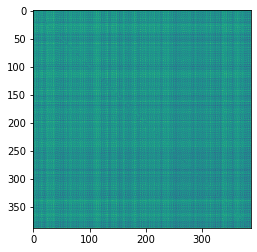

In [43]:
plt.imshow(distances.cpu()[0].detach().numpy())

In [ ]:
# gotta debug this NaNs after first pass

# UTILS FOR LATER BUILD-UP OF COOL TRAINING SCRIPT (NOT USED FOR NOW)

### Train plot

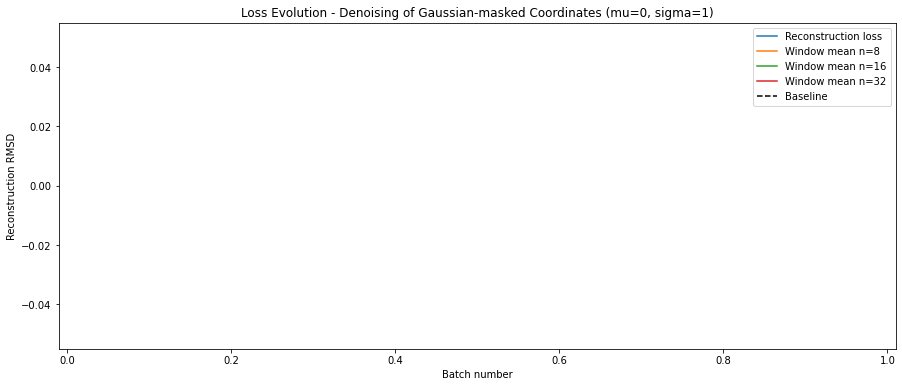

In [78]:
plt.figure(figsize=(15,6))
plt.title("Loss Evolution - Denoising of Gaussian-masked Coordinates (mu=0, sigma=1)")
plt.plot(epoch_losses, label="Reconstruction loss")

for window in [8,16,32]:
    plt.plot([np.mean(epoch_losses[:window][0:i+1]) for i in range(min(window, len(epoch_losses))) ] + \
             [np.mean(epoch_losses[i:i+window+1]) for i in range(len(epoch_losses)-window)], 
             label="Window mean n={0}".format(window))

plt.plot(np.ones(len(epoch_losses)) * np.mean(baseline_losses), "k--", label="Baseline")
    
# plt.yscale("log")
plt.xlim(-0.01*len(epoch_losses),1.01*len(epoch_losses))
# plt.yscale("log")
plt.ylabel("Reconstruction RMSD")
plt.xlabel("Batch number")
plt.legend()
plt.show()

In [ ]:
print("MSE between random coords: ", ((base_coords - target_coords)**2).mean() )

MSE between masked coords:  tensor(0.9803, device='cuda:0')


In [ ]:
# rotate / align
pred_aligned, target_aligned = kabsch_torch(pred_coords.t(), target_coords.t()) # (3, N)
print("MSE between reconstructed coords: ", ((pred_aligned.t() - target_aligned.t())[flat_chain_mask[flat_cloud_mask]]**2).mean() )

MSE between reconstructed coords:  tensor(0.1991, device='cuda:0', grad_fn=<MeanBackward0>)


### Protein plots

In [ ]:
scaffs  = {"cloud_mask": scn_cloud_mask(seq_str[:-padding_seq or None]).bool()}
wrapper = torch.zeros(*scaffs["cloud_mask"].shape, 3).cpu()
# rebuild target
target_rebuilt = wrapper.clone()
target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# rebuild encoded-decoded
pre_target_rebuilt = wrapper.clone()
pre_target_rebuilt[scaffs["cloud_mask"].cpu()] = target_aligned.t().cpu()
# build input coords (w/out sidechain)
input_rebuilt = wrapper.clone()
input_rebuilt[scaffs["cloud_mask"].cpu()] = base_coords.cpu()
# build predicted
pred_rebuilt = wrapper.clone()
pred_rebuilt[scaffs["cloud_mask"].cpu()] = pred_aligned.t().cpu()

In [ ]:
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq_str[:-padding_seq or None]]),
                                    crd=rearrange(pre_target_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# label
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq_str[:-padding_seq or None]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# reconstructed
sb = sidechainnet.StructureBuilder( torch.tensor([AAS.index(x) for x in seq_strseq[:-padding_seq or None]]),
                                    crd=rearrange(input_rebuilt, 'l c d -> (l c) d') ) # pred_rebuilt
sb.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Addendum (not used)